In [372]:
import KID_model_functions as kids
import fitting_KID_model_functions as fitkids
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy import units as u

In [373]:
alpha = 0.73*u.dimensionless_unscaled
f = 331.6*u.MHz
Tstage = 0.215*u.K
Tc = 1.39*u.K
TBB_0 = 6.0*u.K
V = 38*1.5*0.8*np.power(u.micron,3) # volume w/20nm film is 38um3, multiply by 1.5 for ~30nm film, minus 20% for overetching trace width
eta_pb = 0.57
nu_opt = (350*u.micron).to(u.GHz,equivalencies=u.spectral())
N0=1.72e10*np.power(u.micron,-3)*np.power(u.eV,-1)

In [374]:
trans=0.03

eta_opt = 0.8*u.dimensionless_unscaled
n_star = 1318*(np.power(u.micron,-3))
tau_max = 35*u.microsecond

In [375]:
TBBoptdata,f0optdata,xoptdata,sxxoptdata = np.loadtxt('optical_response_evap_devices/CD012_reduced_Res0.csv',delimiter=',',unpack=True)

In [376]:
Pincoptdata = kids.TBB_to_Pinc(TBBoptdata,trans=trans)

In [377]:
TBBoptpts = np.sort(list(set(TBBoptdata)))
Pincoptpts = kids.TBB_to_Pinc(TBBoptpts,trans=trans)

In [378]:
f0optpts = []
f0opterr = []
xoptpts = []
xopterr = []
sxxoptpts = []
sxxopterr = []


In [379]:
for temp in TBBoptpts:
    inds = np.where(TBBoptdata == temp)
    
    f0optpts.append(np.average(f0optdata[inds]))
    f0opterr.append(np.std(f0optdata[inds])/np.sqrt(len(inds)))
    
    xoptpts.append(np.average(xoptdata[inds]))
    xopterr.append(np.std(xoptdata[inds])/np.sqrt(len(inds)))
    
    sxxoptpts.append(np.average(sxxoptdata[inds]))
    sxxopterr.append(np.std(sxxoptdata[inds])/np.sqrt(len(inds)))
    

In [380]:
Tstagedarkdata,f0darkdata,xdarkdata,sxxdarkdata = np.loadtxt('optical_response_evap_devices/CD011_reduced_Res0.csv',delimiter=',',unpack=True)

In [381]:
Tstagedarkpts = np.sort(list(set(Tstagedarkdata)))
f0darkpts = []
f0darkerr = []
xdarkpts = []
xdarkerr = []
sxxdarkpts = []
sxxdarkerr = []

In [382]:
for temp in Tstagedarkpts:
    inds = np.where(Tstagedarkdata == temp)
    
    f0darkpts.append(np.average(f0darkdata[inds]))
    f0darkerr.append(np.std(f0darkdata[inds])/np.sqrt(len(inds)))
    
    xdarkpts.append(np.average(xdarkdata[inds]))
    xdarkerr.append(np.std(xdarkdata[inds])/np.sqrt(len(inds)))
    
    sxxdarkpts.append(np.average(sxxdarkdata[inds]))
    sxxdarkerr.append(np.std(sxxdarkdata[inds])/np.sqrt(len(inds)))
    

In [383]:
alpha = 0.73*u.dimensionless_unscaled
f = 331.6*u.MHz
Tc = 1.39*u.K
TBB_0 = 6.0*u.K
V = 76*np.power(u.micron,3)#38*1.5*0.8*np.power(u.micron,3) # volume w/20nm film is 38um3, multiply by 1.5 for ~30nm film, minus 20% for overetching trace width
eta_pb = 0.57
nu_opt = (350*u.micron).to(u.GHz,equivalencies=u.spectral())
N0=1.72e10*np.power(u.micron,-3)*np.power(u.eV,-1)

trans=0

eta_opt = 0.17*u.dimensionless_unscaled
n_star = 1392*(np.power(u.micron,-3))
tau_max = 20*u.microsecond

Sxx_0dark = 1.75e-17*np.power(u.Hz,-1)

Tstagedarkmod = np.linspace(0.210,0.35,num=50)
Sxxdarkmod = kids.Sxx(alpha,f,Tstagedarkmod,Tc,TBB_0,V,n_star,tau_max,eta_pb,nu_opt,eta_opt,trans=0,N0=N0)+Sxx_0dark

In [384]:
alpha = 0.73*u.dimensionless_unscaled
f = 331.6*u.MHz
Tc = 1.39*u.K
TBB_0 = 6.0*u.K
V = 38*1.5*0.8*np.power(u.micron,3) # volume w/20nm film is 38um3, multiply by 1.5 for ~30nm film, minus 20% for overetching trace width
eta_pb = 0.57
nu_opt = (350*u.micron).to(u.GHz,equivalencies=u.spectral())
N0=1.72e10*np.power(u.micron,-3)*np.power(u.eV,-1)

trans=0

eta_opt = 0.8*u.dimensionless_unscaled
n_star = 100*(np.power(u.micron,-3))
tau_max = 100*u.microsecond

Sxx_0dark = .5e-17*np.power(u.Hz,-1)

Tstagedarkmod2 = np.linspace(0.210,0.35,num=50)
Sxxdarkmod2 = kids.Sxx(alpha,f,Tstagedarkmod,Tc,TBB_0,V,n_star,tau_max,eta_pb,nu_opt,eta_opt,trans=0,N0=N0)+Sxx_0dark

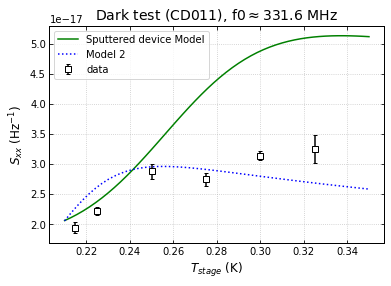

In [385]:
plt.errorbar(x=Tstagedarkpts,y=sxxdarkpts,yerr=sxxdarkerr,linestyle=None,fmt='s',markerfacecolor='w',markeredgecolor='k',ecolor='k',label='data')
plt.plot(Tstagedarkmod,Sxxdarkmod,'g-',label='Sputtered device Model')
plt.plot(Tstagedarkmod2,Sxxdarkmod2,'b:',label='Model 2')
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
plt.xlabel(r'$T_{stage}$ (K)')
plt.ylabel(r'$S_{xx}$ (Hz$^{-1}$)')
plt.title(r'Dark test (CD011), f0$\approx$331.6 MHz')
plt.legend(loc='upper left')
plt.savefig('CD011_res0_sxx_vs_Tstage.png')
#plt.plot(Tstagedarkdata,sxxdarkdata,'ko')

In [386]:
alpha = 0.73*u.dimensionless_unscaled
f = 331.6*u.MHz
Tc = 1.39*u.K
Tstage_0 = .215*u.K
V = 76*np.power(u.micron,3)#38*1.5*0.8*np.power(u.micron,3) # volume w/20nm film is 38um3, multiply by 1.5 for ~30nm film, minus 20% for overetching trace width
eta_pb = 0.57
nu_opt = (350*u.micron).to(u.GHz,equivalencies=u.spectral())
N0=1.72e10*np.power(u.micron,-3)*np.power(u.eV,-1)

trans=0.03

eta_opt = 0.17*u.dimensionless_unscaled
n_star = 1392*(np.power(u.micron,-3))
tau_max = 20*u.microsecond

Sxx_0opt = 1.75e-17*np.power(u.Hz,-1)

TBBoptmod = np.linspace(5,8,num=50)
Pincoptmod = kids.TBB_to_Pinc(TBBoptmod,trans)
xoptmod = kids.xMB(alpha,f,Tstage_0,Tc,TBBoptmod,V,n_star,tau_max,eta_pb,eta_opt,trans=trans,N0=N0)
Sxxoptmod = kids.Sxx(alpha,f,Tstage_0,Tc,TBBoptmod,V,n_star,tau_max,eta_pb,nu_opt,eta_opt,trans=trans,N0=N0)+Sxx_0dark

In [387]:
alpha = 0.73*u.dimensionless_unscaled
f = 331.6*u.MHz
Tc = 1.39*u.K
Tstage_0 = .215*u.K
V = 38*1.5*0.8*np.power(u.micron,3) # volume w/20nm film is 38um3, multiply by 1.5 for ~30nm film, minus 20% for overetching trace width
eta_pb = 0.57
nu_opt = (350*u.micron).to(u.GHz,equivalencies=u.spectral())
N0=1.72e10*np.power(u.micron,-3)*np.power(u.eV,-1)

trans=0.03

eta_opt = 0.8*u.dimensionless_unscaled
n_star = 100*(np.power(u.micron,-3))
tau_max = 50*u.microsecond

Sxx_0opt = 1.75e-17*np.power(u.Hz,-1)

TBBoptmod2 = np.linspace(5,8,num=50)
Pincoptmod2 = kids.TBB_to_Pinc(TBBoptmod2,trans)
xoptmod2 = kids.xMB(alpha,f,Tstage_0,Tc,TBBoptmod,V,n_star,tau_max,eta_pb,eta_opt,trans=trans,N0=N0)
Sxxoptmod2 = kids.Sxx(alpha,f,Tstage_0,Tc,TBBoptmod,V,n_star,tau_max,eta_pb,nu_opt,eta_opt,trans=trans,N0=N0)+Sxx_0dark

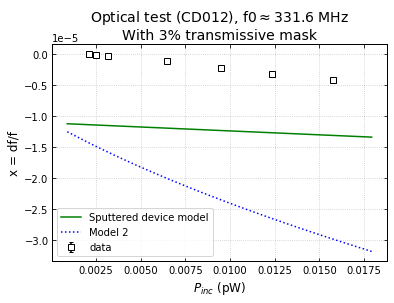

In [388]:
plt.errorbar(x=Pincoptpts.value,y=xoptpts,yerr=xopterr,linestyle=None,fmt='s',markerfacecolor='w',markeredgecolor='k',ecolor='k',label='data')
plt.plot(Pincoptmod,xoptmod,'g-',label='Sputtered device model')
plt.plot(Pincoptmod2,xoptmod2,'b:',label='Model 2')
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
plt.xlabel(r'$P_{inc}$ (pW)')
plt.ylabel('x = df/f')
plt.title(r'Optical test (CD012), f0$\approx$331.6 MHz' + '\n' + 'With 3% transmissive mask')
plt.legend(loc='lower left')
plt.savefig('CD012_res0_x_vs_Pinc.png')


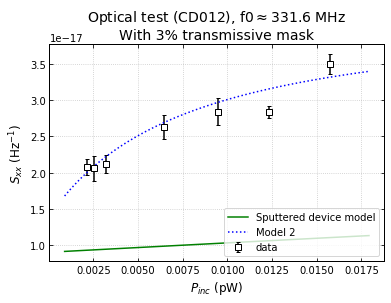

In [389]:
plt.errorbar(x=Pincoptpts.value,y=sxxoptpts,yerr=sxxopterr,linestyle=None,fmt='s',markerfacecolor='w',markeredgecolor='k',ecolor='k',label='data')
plt.plot(Pincoptmod,Sxxoptmod,'g-',label='Sputtered device model')
plt.plot(Pincoptmod2,Sxxoptmod2,'b:',label='Model 2')
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
plt.xlabel(r'$P_{inc}$ (pW)')
plt.ylabel(r'$S_{xx}$ (Hz$^{-1}$)')
plt.title(r'Optical test (CD012), f0$\approx$331.6 MHz' + '\n' + 'With 3% transmissive mask')
plt.legend(loc='lower right')
plt.savefig('CD012_res0_sxx_vs_Pinc.png')
#plt.plot(Pincoptdata,sxxoptdata,'ko')